In [1]:
import pandas as pd
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

In [2]:
read_final = True

if read_final:
    product = pd.read_pickle('./datathon/dataset/final_products')
    outfits = pd.read_pickle('./datathon/dataset/final_outfits')
else:
    o_outfits= pd.read_csv('./datathon/dataset/outfit_data.csv')
    o_product = pd.read_csv('./datathon/dataset/product_data.csv')

    outfits = o_outfits.copy()
    product = o_product.copy()

    #Deleting all the products that are not clothes
    product = product[(product.des_product_category!= 'Beauty') & (product.des_product_category!= 'Home')]
    # Delete all products for men and kids due to desbalance
    product = product[(product.des_line== 'SHE')]
    product = product[(product.des_sex== 'Female')]
    product = product[(product.des_age== 'Adult')]
    product = product[~product.des_product_aggregated_family.isin(['Dresses and jumpsuits','Swim and intimate','Accessories'])]
    product['des_product_category'] = product['des_product_category'].apply(lambda x: 'Tops' if x =='Outerwear' else x)
    product =product.drop(['des_sex','des_line','des_age'], axis = 1)

    # Delete the deleted products from outfits
    outfits = outfits[outfits.cod_modelo_color.isin(product.cod_modelo_color.unique())]

In [3]:
product.head()

,cod_modelo_color,cod_color_code,des_color_specification_esp,des_agrup_color_eng,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename,emb
0,41085800-02,02,OFFWHITE,WHITE,P-PLANA,Bottoms,Trousers & leggings,Trousers,Trousers,datathon/images/2019_41085800_02.jpg,"[1.6967614, 1.6967614, 1.6967614, 1.6967614, 1..."
1,53000586-TO,TO,TEJANO OSCURO,BLUE,J-JEANS,Bottoms,Jeans,Jeans,Jeans,datathon/images/2019_53000586_TO.jpg,"[1.6821629, 1.6967614, 1.6967614, 1.6967614, 1..."
4,53070773-70,70,ROJO,RED,P-PLANA,Tops,Shirts,Shirt,Shirt,datathon/images/2019_53070773_70.jpg,"[1.6383677, 1.6383677, 1.6383677, 1.6383677, 1..."
5,53003736-94,94,GRIS MEDIO VIGORE,GREY,T-TRICOT,Tops,Sweaters and Cardigans,Sweater,Sweater,datathon/images/2019_53003736_94.jpg,"[1.5799739, 1.5799739, 1.5653756, 1.5653756, 1..."
6,53045718-17,17,CARAMELO,YELLOW,T-TRICOT,Tops,Sweaters and Cardigans,Sweater,Sweater,datathon/images/2019_53045718_17.jpg,"[1.5507771, 1.5653756, 1.5799739, 1.5799739, 1..."


## AUX FUNCTIONS 

In [4]:
def getProductIdx(idx):
    print("DATOS DEL PRODUCTO")
    print(product.iloc[idx])
    print('OUTFITS APPEARING IN:')
    code = product.iloc[idx].cod_modelo_color
    print(list(outfits[outfits.cod_modelo_color==code]['cod_outfit'].unique()))
    print('IMAGE')
    image_path =product.loc[idx]['des_filename']
    img = cv2.imread(image_path)
    plt.imshow(img)


In [5]:
def getProductByCode(code,datos = False):
    if datos:
        print("DATOS DEL PRODUCTO")
        print(product.loc[product.cod_modelo_color == code])
        print('OUTFITS APPEARING IN:')
        print(list(outfits[outfits.cod_modelo_color==code]['cod_outfit'].unique()))
        print('IMAGE')
    image_path =product[product.cod_modelo_color == code]['des_filename'].values[0]
    img = cv2.imread(image_path)
    plt.imshow(img)


In [6]:
def printOutfitByCodes(cloths):
    for i in cloths:
        image_path =product[product.cod_modelo_color == i]['des_filename'].values[0]
        img = cv2.imread(image_path)
        plt.imshow(img)
        plt.show()

In [7]:
def printOufitByIdx(outfit):
    listaPrednas =  outfits[outfits.cod_outfit==outfit]['cod_modelo_color'].unique()
    for i in listaPrednas:
        image_path =product[product.cod_modelo_color == i]['des_filename'].values[0]
        img = cv2.imread(image_path)
        plt.imshow(img)
        plt.show()

In [8]:
def getEmbeding(code):
    if code == None:
        return None
    return product[product.cod_modelo_color==code]['emb'].values

In [9]:
# Calulate probabilities
outfits['col'] = outfits['cod_modelo_color'].apply(lambda x: x.split('-')[1])
df_grouped = outfits.groupby('cod_outfit')['col'].apply(list).reset_index()

conteo_color = {}
for i in product["cod_color_code"].unique():
    conteo_color[i] = 0
    for j in df_grouped.iloc[:,1].values:
        for k in j:
            if k == i:
                for z in range(0,len(j)):
                    conteo_color[k+j[z]] = 0

for i in product["cod_color_code"].unique():
    conteo_color[i] = 0
    for j in df_grouped.iloc[:,1].values:
        for k in j:
            if k == i:
                conteo_color[i] += 1
                for z in range(0,len(j)):
                    if k != j[z]:
                        conteo_color[k+j[z]] += 1
                    else:
                        conteo_color[k+j[z]] += .5

In [10]:
# Probabilidad condiciional de code2 once you have code 1
def probabilidad_col(colorcode1, colorcode2):
    code = colorcode1 + colorcode2
    prob = conteo_color[code]/conteo_color[colorcode1]
    return prob

In [11]:
outfits['fab'] = outfits["cod_modelo_color"].apply(lambda x: product[(product['cod_modelo_color'] == x)].iloc[0][7])
df_grouped_fab = outfits.groupby('cod_outfit')['fab'].apply(list).reset_index()

tejido = {}
for i in product["des_fabric"].unique():
    tejido[i] = 0
    for j in df_grouped_fab.iloc[:,1].values:
        for k in j:
            if k == i:
                for z in range(0,len(j)):
                    tejido[k+j[z]] = 0

for i in product["des_fabric"].unique():
    tejido[i] = 0
    for j in df_grouped_fab.iloc[:,1].values:
        for k in j:
            if k == i:
                tejido[i] += 1 * len(j)
                for z in range(0,len(j)):
                    if k != j[z]:
                        tejido[k+j[z]] += 1
                    else:
                        tejido[k+j[z]] += .5

In [12]:
def probabilidad_fab(fabric1, fabric2):
    fabric = fabric1 + fabric2
    try:
        prob = tejido[fabric]/tejido[fabric1]
        return prob
    except:
        return 0

# BUSQUEDA LOCAL

In [13]:
def computeHeuristicPorbs(codes):
    
    fab1 = product[product.cod_modelo_color==codes[0]]['des_fabric'].values[0]
    fab2 = product[product.cod_modelo_color==codes[1]]['des_fabric'].values[0]
    
    col1 = product[product.cod_modelo_color==codes[0]]['cod_color_code'].values[0]
    col2 = product[product.cod_modelo_color==codes[1]]['cod_color_code'].values[0]
    a=0
    b=0
    c=0
    d=0
    if len(codes) ==3:
        fab3 = product[product.cod_modelo_color==codes[2]]['des_fabric'].values[0]
        col3 = product[product.cod_modelo_color==codes[2]]['cod_color_code'].values[0]
        b=probabilidad_fab(fab1,fab3)
        d=probabilidad_col(col1,col3)
        
    a=probabilidad_fab(fab1,fab2)   
    c=probabilidad_col(col1,col2)
    
    mean= (a+b+c+d) /len(codes)
    return mean

In [14]:
computeHeuristicPorbs(['51000622-02','43067759-01'])

0.14753587024329382

In [15]:
def computeHeuristic(embedings):
    sum_distances=0
    for i in range(len(embedings)):
        for j in range(i + 1, len(embedings)):
            distance_ij = np.linalg.norm(embedings[i][0] - embedings[j][0])
            sum_distances += distance_ij
    return sum_distances

In [16]:
def getNewProdSucc(estado, part):    
    data = product.copy()
    match part:
        case "top":
            data  = product.loc[product['des_product_category'] == "Tops"]
        case "bot":
            data =  product.loc[product['des_product_category'] == "Bottoms"]
        case "shoes":
            data  = product.loc[product['des_product_family'] == "Footwear"]
    
    randomObs = data.sample(1)
    newProd = randomObs.cod_modelo_color.values[0]
    return newProd

In [17]:
MAX_DEPTH = 5

In [18]:
def hillClimbing(estado):
    successors = []
    random_seed = None
    
    # top sucesores
    topPart = None
    while (topPart == None):
        topPart = getNewProdSucc(estado, "top")
        newState = State(topPart, estado.get_bot(), estado.get_shoes(),depth=(estado.get_depth()+1))
        
        newStateH = newState.get_heuristica()
        if(newStateH < estado.get_heuristica()):
            topPart = None
        else:
            successors.append((newState, newState.get_heuristica()))
        
    
    # bottom sucesores
    bottomPart = None
    while(bottomPart == None):
        bottomPart = getNewProdSucc(estado, "bot")
        newState = State(estado.get_top(), bottomPart, estado.get_shoes(),depth=(estado.get_depth()+1))
        
        newStateH = newState.get_heuristica()
        if(newStateH < estado.get_heuristica()):
            bottomPart = None
        else:
            successors.append((newState, newState.get_heuristica()))
        
    # zapatos sucesores
    shoesPart = None
    while (shoesPart == None):
        shoesPart = getNewProdSucc(estado, "shoes")
        newState = State(estado.get_top(), estado.get_bot(), shoesPart, depth=(estado.get_depth()+1))
        
        newStateH = newState.get_heuristica()
        if(newStateH < estado.get_heuristica()):
            shoesPart = None
        else:
            successors.append((newState, newState.get_heuristica()))
        
    
    if (len(successors) == 0 or (estado.get_depth()) > 5): return estado
    
    # get first as best
    maxH = successors[0][1]
    bestSuccessor = successors[0][0]
    
    for succ in successors:
        if(maxH < succ[1]):
            maxH = succ[1]
            bestSuccessor = succ[0]
#     print(bestSuccessor.get_depth())
    
    return hillClimbing(bestSuccessor)

In [73]:
class State:
    def __init__(self, top=None, bot=None, shoes=None, heuristica=np.inf, depth = 0):
        self.top = top
        self.bot = bot
        self.shoes = shoes
        self.heuristica = heuristica
        self._depth = depth
        if (self.top!= None or self.shoes!=None or self.bot!=None): self.heuristica = computeHeuristic(self.getAllEmbedings())
        
    def getAllEmbedings(self):
        embedings = [getEmbeding(self.top),getEmbeding(self.bot),getEmbeding(self.shoes)]
        embedings = [value for value in embedings if value is not None]
        return embedings

        
    def getProducts(self):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))  # Create a 1x3 grid of subplots

        # Top
        top_image_path = product[product.cod_modelo_color == self.top]['des_filename'].values[0]
        top_img = cv2.imread(top_image_path)
        axs[0].imshow(top_img)
        axs[0].set_title('Top')

        # Bottom
        bot_image_path = product[product.cod_modelo_color == self.bot]['des_filename'].values[0]
        bot_img = cv2.imread(bot_image_path)
        axs[1].imshow(bot_img)
        axs[1].set_title('Bottom')

        # Shoes
        shoes_image_path = product[product.cod_modelo_color == self.zapatos]['des_filename'].values[0]
        shoes_img = cv2.imread(shoes_image_path)
        axs[2].imshow(shoes_img)
        axs[2].set_title('Shoes')

        plt.show()
    def show_top(self):
        return getProductByCode(self.top)

    def show_bot(self):
        return getProductByCode(self.bot)

    def show_shoes(self):
        return getProductByCode(self.shoes)
    
    def get_top(self):
        return self.top

    def get_bot(self):
        return self.bot

    def get_shoes(self):
        return self.shoes
    
    def get_depth(self):
        return self._depth
    
    def get_heuristica(self):
        return self.heuristica

In [74]:
outfit0= State(top='51000622-02',bot='43067759-01')

In [75]:
out_fin= hillClimbing(outfit0)

In [76]:
top = out_fin.get_top()
bot = out_fin.get_bot()
shoes = out_fin.get_shoes()

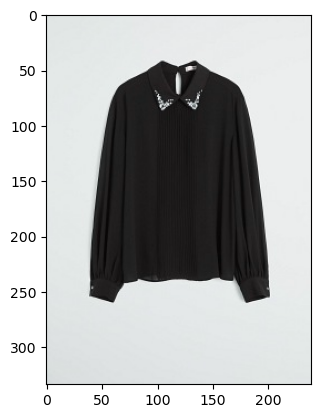

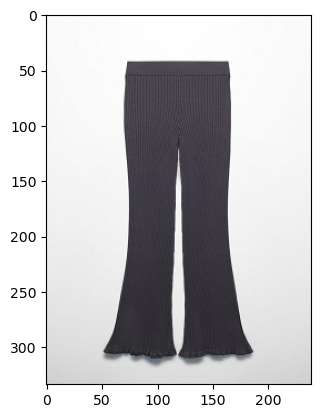

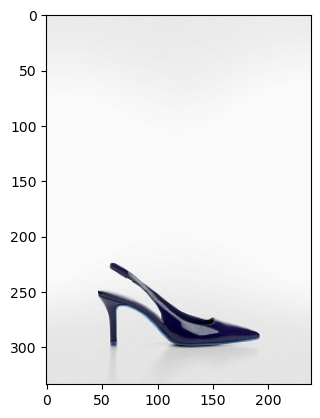

In [77]:
printOutfitByCodes([top,bot,shoes])

In [29]:
def getOutfitByTop(code):
    outfit= State(top=code)
    out = hillClimbing(outfit)
    top = out.get_top()
    bot = out.get_bot()
    shoes = out.get_shoes()
    
    printOutfitByCodes([top,bot,shoes])
    
def getOutfitByBot(code):
    outfit= State(bot=code)
    out = hillClimbing(outfit)
    top = out.get_top()
    bot = out.get_bot()
    shoes = out.get_shoes()
    
    printOutfitByCodes([top,bot,shoes])
    
def getOutfitByShoes(code):
    outfit= State(shoes=code)
    out = hillClimbing(outfit)
    top = out.get_top()
    bot = out.get_bot()
    shoes = out.get_shoes()
    
    printOutfitByCodes([top,bot,shoes])

In [27]:
def getElement(family):
    fam = family
    if family == 'shoes':
        fam = 'Accesories, Swim and Intimate'
    elif family == 'top':
        fam = 'Tops'
    elif family == 'bot':
        fam = 'Bottoms'
    return product[product.des_product_category == fam].sample(1)['cod_modelo_color'].values[0]

## Example outfit 1

PRODUCT SELECTED
OUTFIT GENERATED


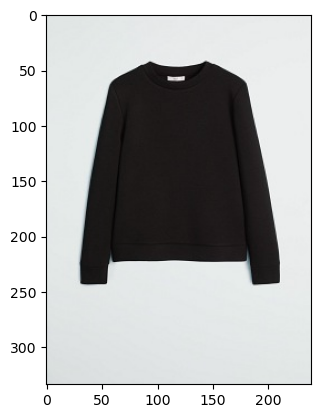

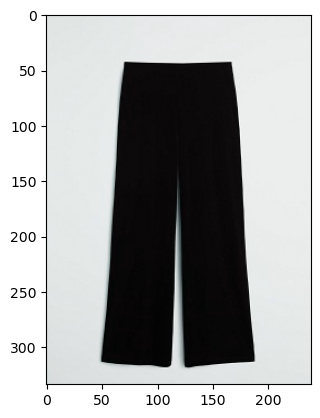

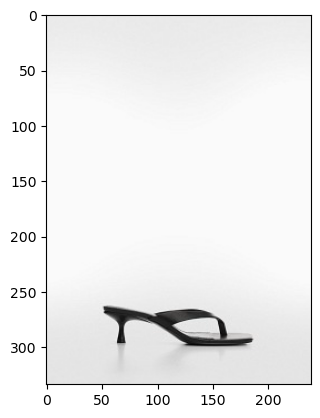

In [31]:
FAM = 'top'

print('PRODUCT SELECTED')
code = getElement(FAM)
# getProductByCode(code)

print('OUTFIT GENERATED')
if FAM == 'top':
    getOutfitByTop(code)
elif FAM == 'bot':
    getOutfitByBot(code)
elif FAM == 'shoes':
    getOutfitByShoes(code)

## Example outfit 2

PRODUCT SELECTED
OUTFIT GENERATED


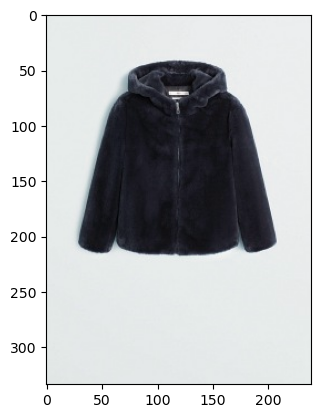

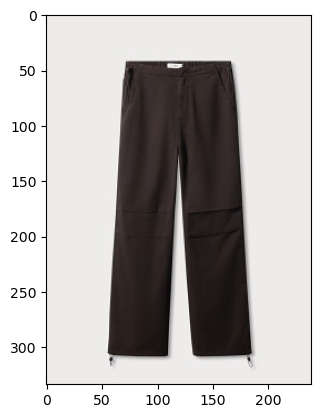

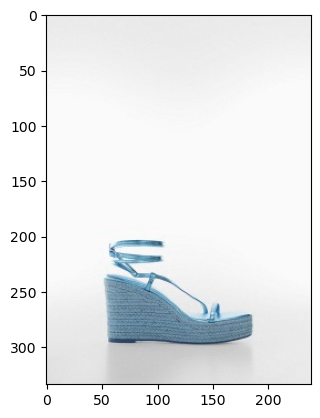

In [33]:
FAM = 'bot'

print('PRODUCT SELECTED')
code = getElement(FAM)
# getProductByCode(code)

print('OUTFIT GENERATED')
if FAM == 'top':
    getOutfitByTop(code)
elif FAM == 'bot':
    getOutfitByBot(code)
elif FAM == 'shoes':
    getOutfitByShoes(code)

## Outfit Example 3

PRODUCT SELECTED
OUTFIT GENERATED


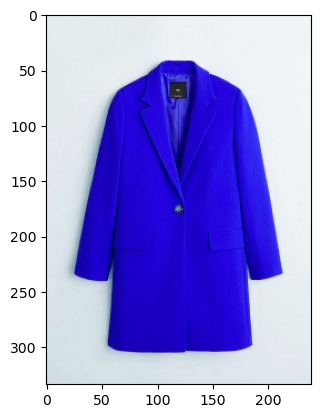

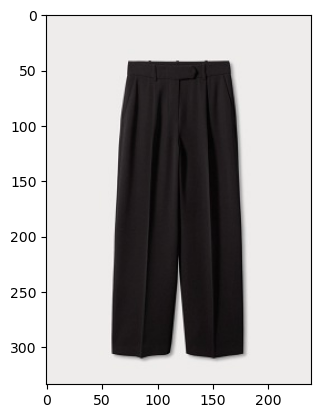

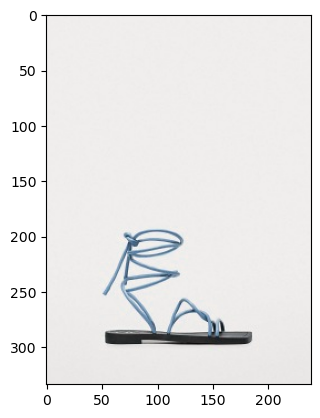

In [40]:
FAM = 'shoes'

print('PRODUCT SELECTED')
code = getElement(FAM)
# getProductByCode(code)

print('OUTFIT GENERATED')
if FAM == 'top':
    getOutfitByTop(code)
elif FAM == 'bot':
    getOutfitByBot(code)
elif FAM == 'shoes':
    getOutfitByShoes(code)

## New Example 

PRODUCT SELECTED
OUTFIT GENERATED


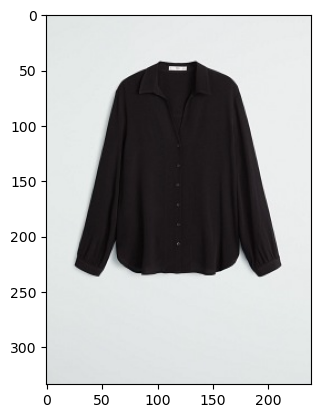

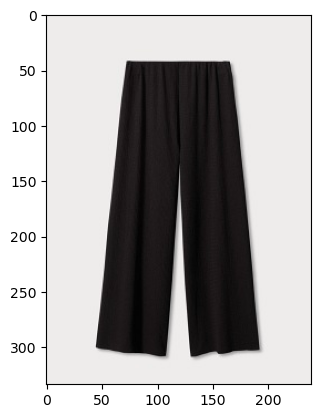

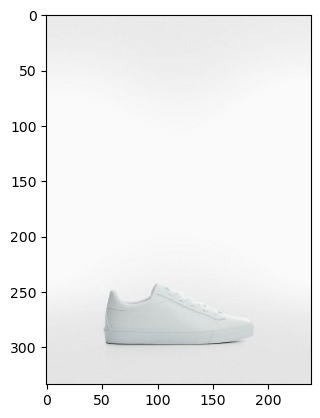

In [42]:
FAM = 'top'

print('PRODUCT SELECTED')
code = getElement(FAM)
# getProductByCode(code)

print('OUTFIT GENERATED')
if FAM == 'top':
    getOutfitByTop(code)
elif FAM == 'bot':
    getOutfitByBot(code)
elif FAM == 'shoes':
    getOutfitByShoes(code)

PRODUCT SELECTED
OUTFIT GENERATED


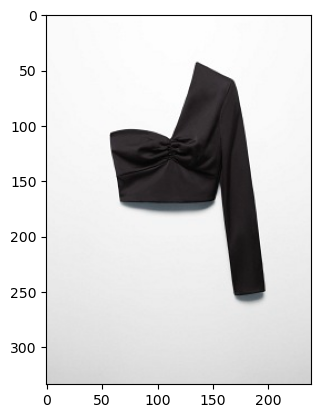

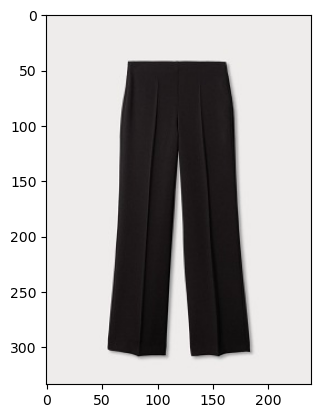

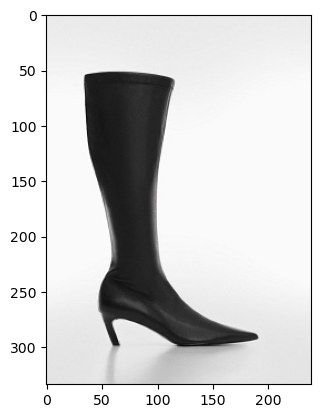

In [44]:
FAM = 'top'

print('PRODUCT SELECTED')
code = getElement(FAM)
# getProductByCode(code)

print('OUTFIT GENERATED')
if FAM == 'top':
    getOutfitByTop(code)
elif FAM == 'bot':
    getOutfitByBot(code)
elif FAM == 'shoes':
    getOutfitByShoes(code)

PRODUCT SELECTED
OUTFIT GENERATED


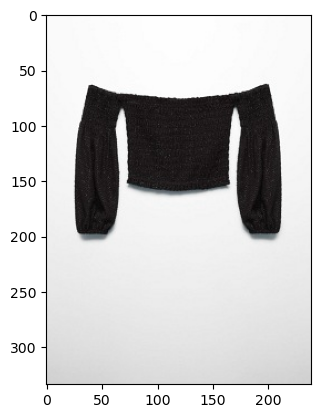

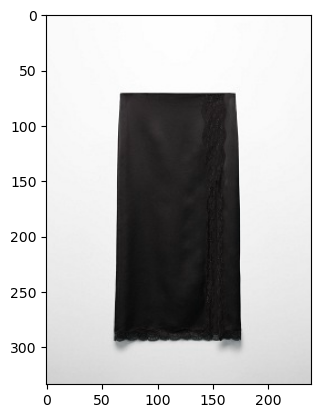

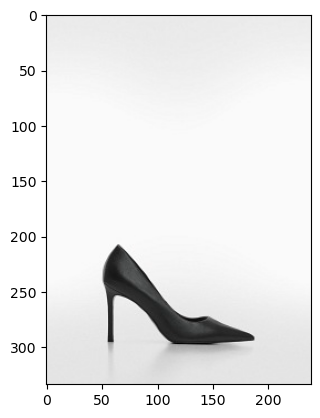

In [63]:
FAM = 'top'

print('PRODUCT SELECTED')
code = getElement(FAM)
# getProductByCode(code)

print('OUTFIT GENERATED')
if FAM == 'top':
    getOutfitByTop(code)
elif FAM == 'bot':
    getOutfitByBot(code)
elif FAM == 'shoes':
    getOutfitByShoes(code)

PRODUCT SELECTED
OUTFIT GENERATED


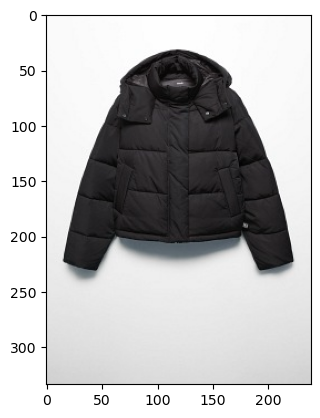

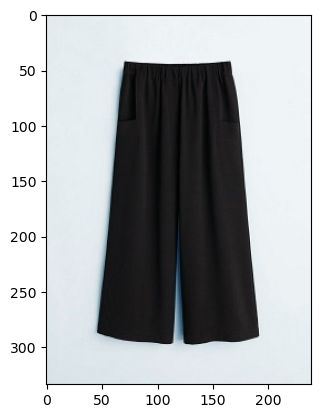

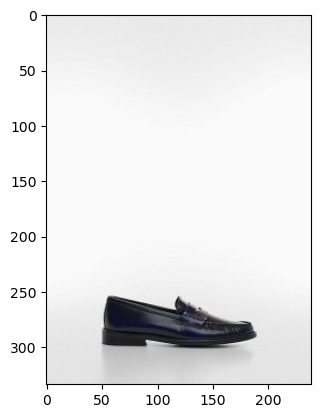

In [78]:
FAM = 'top'

print('PRODUCT SELECTED')
code = getElement(FAM)
# getProductByCode(code)

print('OUTFIT GENERATED')
if FAM == 'top':
    getOutfitByTop(code)
elif FAM == 'bot':
    getOutfitByBot(code)
elif FAM == 'shoes':
    getOutfitByShoes(code)